<a href="https://colab.research.google.com/github/sumantis/Algorithms_DS/blob/master/Parameter_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement
 We just got back from a trip to some obscure location, and we brought back a fancy,
 wall-mounted analog thermometer. It looks great, and it’s a perfect fit for our living
 room. Its only flaw is that it doesn’t show units. Not to worry, we’ve got a plan: we’ll
 build a dataset of readings and corresponding temperature values in our favorite
 units, choose a model, adjust its weights iteratively until a measure of the error is low
 enough, and finally be able to interpret the new readings in units we understand

In [ ]:
%matplotlib inline
import numpy as np
import torch


In [ ]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
#Explanation - When the tempreature was 0.5 degree celsius, the tempreature in some obsure units which was observed is 35.7
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

### Choosing a Linear Model as the first try

```
t_c=w*t_w + b

w=weight
b=bias
```

In [ ]:
def model(t_u, w, b):
    return w * t_u + b

#We’re expecting t_u, w, and b to be the input tensor, weight parameter, and bias parameter, respectively.
#he parameters will be PyTorch scalars (aka 0 dimensional vectors) and the product operation will use broadcasting to yield the returned tensors


### Loss function
we still need to exactly define a measure of the error. Such a measure, which we refer to as the loss function, should be high if the error is high and should ideally be as low as possible for a perfect match

### Less loss is what we want
A loss function (or cost function) is a function that computes a single numerical value that the learning process will attempt to minimize. The calculation of loss typically involves taking the difference between the desired outputs for some training samples and the outputs actually produced by the model when fed those samples. In our case,that would be the difference between the predicted temperatures t_p output by our
model and the actual measurements: t_p – t_c.

We need to make sure the loss function makes the loss positive both when t_p is greater than and when it is less than the true t_c, since the goal is for t_p to match t_c.We have a few choices, the most straightforward being |t_p – t_c| and (t_p – t_c)^2.

In [ ]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [ ]:
w = torch.ones(()) #Start with some random parameters
b = torch.zeros(()) #Start with some random parameters

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [ ]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

In [ ]:
#Broadcasting
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1)
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


### Down the descent
We’ll optimize the loss function with respect to the parameters using the gradient descent algorithm

The idea is to compute the rate of change of the loss with respect to each parameter, and modify each parameter in the direction of decreasing loss. Just like when we were fiddling with the knobs, we can estimate the rate of change by adding a small number to w and
b and seeing how much the loss changes in that neighborhood:

In [ ]:
delta = 0.1

loss_rate_of_change_w =(loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

In [ ]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [ ]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) -
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

### Loss rate of change
In order to compute the derivative of the loss with respect to a parameter, we can apply the chain rule and compute the derivative of the loss with respect to its input (which is the output of the model), times the derivative of the model with respect to the parameter:

```
d loss_fn / d w = (d loss_fn / d t_p) * (d t_p / d w)
```

In [ ]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

In [ ]:
#Differentiation of model wrt d_w
def dmodel_dw(t_u, w, b):
    return t_u

In [ ]:
#Differentiation of the model wrt du
def dmodel_db(t_u, w, b):
    return 1.0

In [ ]:
#Writing all of this together
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  # <1>

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        print(f"Epoch {epoch}, Loss:{float(loss)}")
        # print(f"{params}")
        if epoch in {1,2,3,10,40,50,60,80,100,500,1000}:
            if print_params:
                print(f"Params: {params},Grads:{grad}")

        if not torch.isfinite(loss).all():
            break
    return params

In [ ]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss:1763.884765625
Params: tensor([-44.1730,  -0.8260]),Grads:tensor([4517.2964,   82.6000])
Epoch 2, Loss:5802484.5
Params: tensor([2568.4011,   45.1637]),Grads:tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss:19408029696.0
Params: tensor([-148527.7344,   -2616.3931]),Grads:tensor([15109614.0000,   266155.6875])
Epoch 4, Loss:64915905708032.0
Epoch 5, Loss:2.1713052546105344e+17
Epoch 6, Loss:7.262575831529281e+20
Epoch 7, Loss:2.429183416467663e+24
Epoch 8, Loss:8.125122549611731e+27
Epoch 9, Loss:2.717688212084259e+31
Epoch 10, Loss:9.090110518901907e+34
Params: tensor([3.2144e+17, 5.6621e+15]),Grads:tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss:inf


tensor([-1.8590e+19, -3.2746e+17])

## What is the key observation from above ?
<details>
<summary>Click for Answer</summary>
This is a clear sign that params is receiving updates that are too large, and
their values start oscillating back and forth as each update overshoots and the next
overcorrects even more. The optimization process is unstable: it diverges instead of
converging to a minimum. We want to see smaller and smaller updates to params, not
larger
</details>

In [ ]:
# How can we limit the magnitude of learning_rate * grad?
training_loop(
    n_epochs = 100,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss:1763.884765625
Params: tensor([ 0.5483, -0.0083]),Grads:tensor([4517.2964,   82.6000])
Epoch 2, Loss:323.09051513671875
Params: tensor([ 0.3623, -0.0118]),Grads:tensor([1859.5493,   35.7843])
Epoch 3, Loss:78.92963409423828
Params: tensor([ 0.2858, -0.0135]),Grads:tensor([765.4666,  16.5122])
Epoch 4, Loss:37.5528450012207
Epoch 5, Loss:30.540283203125
Epoch 6, Loss:29.351154327392578
Epoch 7, Loss:29.148883819580078
Epoch 8, Loss:29.113847732543945
Epoch 9, Loss:29.107145309448242
Epoch 10, Loss:29.105247497558594
Params: tensor([ 0.2324, -0.0166]),Grads:tensor([1.4803, 3.0544])
Epoch 11, Loss:29.104167938232422
Epoch 12, Loss:29.103221893310547
Epoch 13, Loss:29.102294921875
Epoch 14, Loss:29.10137939453125
Epoch 15, Loss:29.100465774536133
Epoch 16, Loss:29.09954833984375
Epoch 17, Loss:29.098630905151367
Epoch 18, Loss:29.09771728515625
Epoch 19, Loss:29.0967960357666
Epoch 20, Loss:29.09588050842285
Epoch 21, Loss:29.094959259033203
Epoch 22, Loss:29.09404945373535
E

tensor([ 0.2327, -0.0438])

> But there’s another problem: the updates to parameters are very small, so the loss decreases very slowly and eventually stalls. We could
obviate this issue by making learning_rate adaptive: that is, change according to the magnitude of updates. There are optimization schemes that do that

### Normalizing Inputs
We can see that the first-epoch gradient for the weight is about 50 times larger than the gradient for the bias. This means the weight and bias live in differently scaled spaces. If this is the case, a learning rate that’s large enough to meaningfully update one will be so large as to be unstable for the other; and a rate that’s appropriate for the other won’t be large enough to meaningfully change the first. That means we’re not going to be able to update our parameters unless we change something about our formulation of the problem

### Rescaling
There’s a simpler way to keep things in check: changing the inputs so that the gra
dients aren’t quite so different. We can make sure the range of the input doesn’t get
 too far from the range of –1.0 to 1.0, roughly speaking. In our case, we can achieve
 something close enough to that by simply multiplying t_u by 0.1:

In [ ]:
t_un = 0.1 * t_u

In [ ]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un, # <1>
    t_c = t_c)

Epoch 1, Loss:80.36434173583984
Params: tensor([1.7761, 0.1064]),Grads:tensor([-77.6140, -10.6400])
Epoch 2, Loss:37.574913024902344
Params: tensor([2.0848, 0.1303]),Grads:tensor([-30.8623,  -2.3864])
Epoch 3, Loss:30.871076583862305
Params: tensor([2.2094, 0.1217]),Grads:tensor([-12.4631,   0.8587])
Epoch 4, Loss:29.756193161010742
Epoch 5, Loss:29.507152557373047
Epoch 6, Loss:29.3924560546875
Epoch 7, Loss:29.298828125
Epoch 8, Loss:29.208717346191406
Epoch 9, Loss:29.119415283203125
Epoch 10, Loss:29.030488967895508
Params: tensor([ 2.3232, -0.0710]),Grads:tensor([-0.5355,  2.9295])
Epoch 11, Loss:28.941877365112305
Epoch 12, Loss:28.853565216064453
Epoch 13, Loss:28.765552520751953
Epoch 14, Loss:28.6778507232666
Epoch 15, Loss:28.590431213378906
Epoch 16, Loss:28.503318786621094
Epoch 17, Loss:28.4164981842041
Epoch 18, Loss:28.329973220825195
Epoch 19, Loss:28.243741989135742
Epoch 20, Loss:28.157804489135742
Epoch 21, Loss:28.07215118408203
Epoch 22, Loss:27.986797332763672
Epo

tensor([ 2.7553, -2.5162])

In [ ]:
params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss:80.36434173583984
Epoch 2, Loss:37.574913024902344
Epoch 3, Loss:30.871076583862305
Epoch 4, Loss:29.756193161010742
Epoch 5, Loss:29.507152557373047
Epoch 6, Loss:29.3924560546875
Epoch 7, Loss:29.298828125
Epoch 8, Loss:29.208717346191406
Epoch 9, Loss:29.119415283203125
Epoch 10, Loss:29.030488967895508
Epoch 11, Loss:28.941877365112305
Epoch 12, Loss:28.853565216064453
Epoch 13, Loss:28.765552520751953
Epoch 14, Loss:28.6778507232666
Epoch 15, Loss:28.590431213378906
Epoch 16, Loss:28.503318786621094
Epoch 17, Loss:28.4164981842041
Epoch 18, Loss:28.329973220825195
Epoch 19, Loss:28.243741989135742
Epoch 20, Loss:28.157804489135742
Epoch 21, Loss:28.07215118408203
Epoch 22, Loss:27.986797332763672
Epoch 23, Loss:27.9017276763916
Epoch 24, Loss:27.81694984436035
Epoch 25, Loss:27.732463836669922
Epoch 26, Loss:27.648256301879883
Epoch 27, Loss:27.56434440612793
Epoch 28, Loss:27.4807071685791
Epoch 29, Loss:27.397361755371094
Epoch 30, Loss:27.314294815063477
Epoch 31,

tensor([  5.3671, -17.3012])

> the values for w and b look an awful lot like the numbers we need to use to convert Celsius to Fahrenheit (after accounting for our earlier normalization when we multiplied our inputs by 0.1). The exact values would be w=5.5556 and b=17.7778.

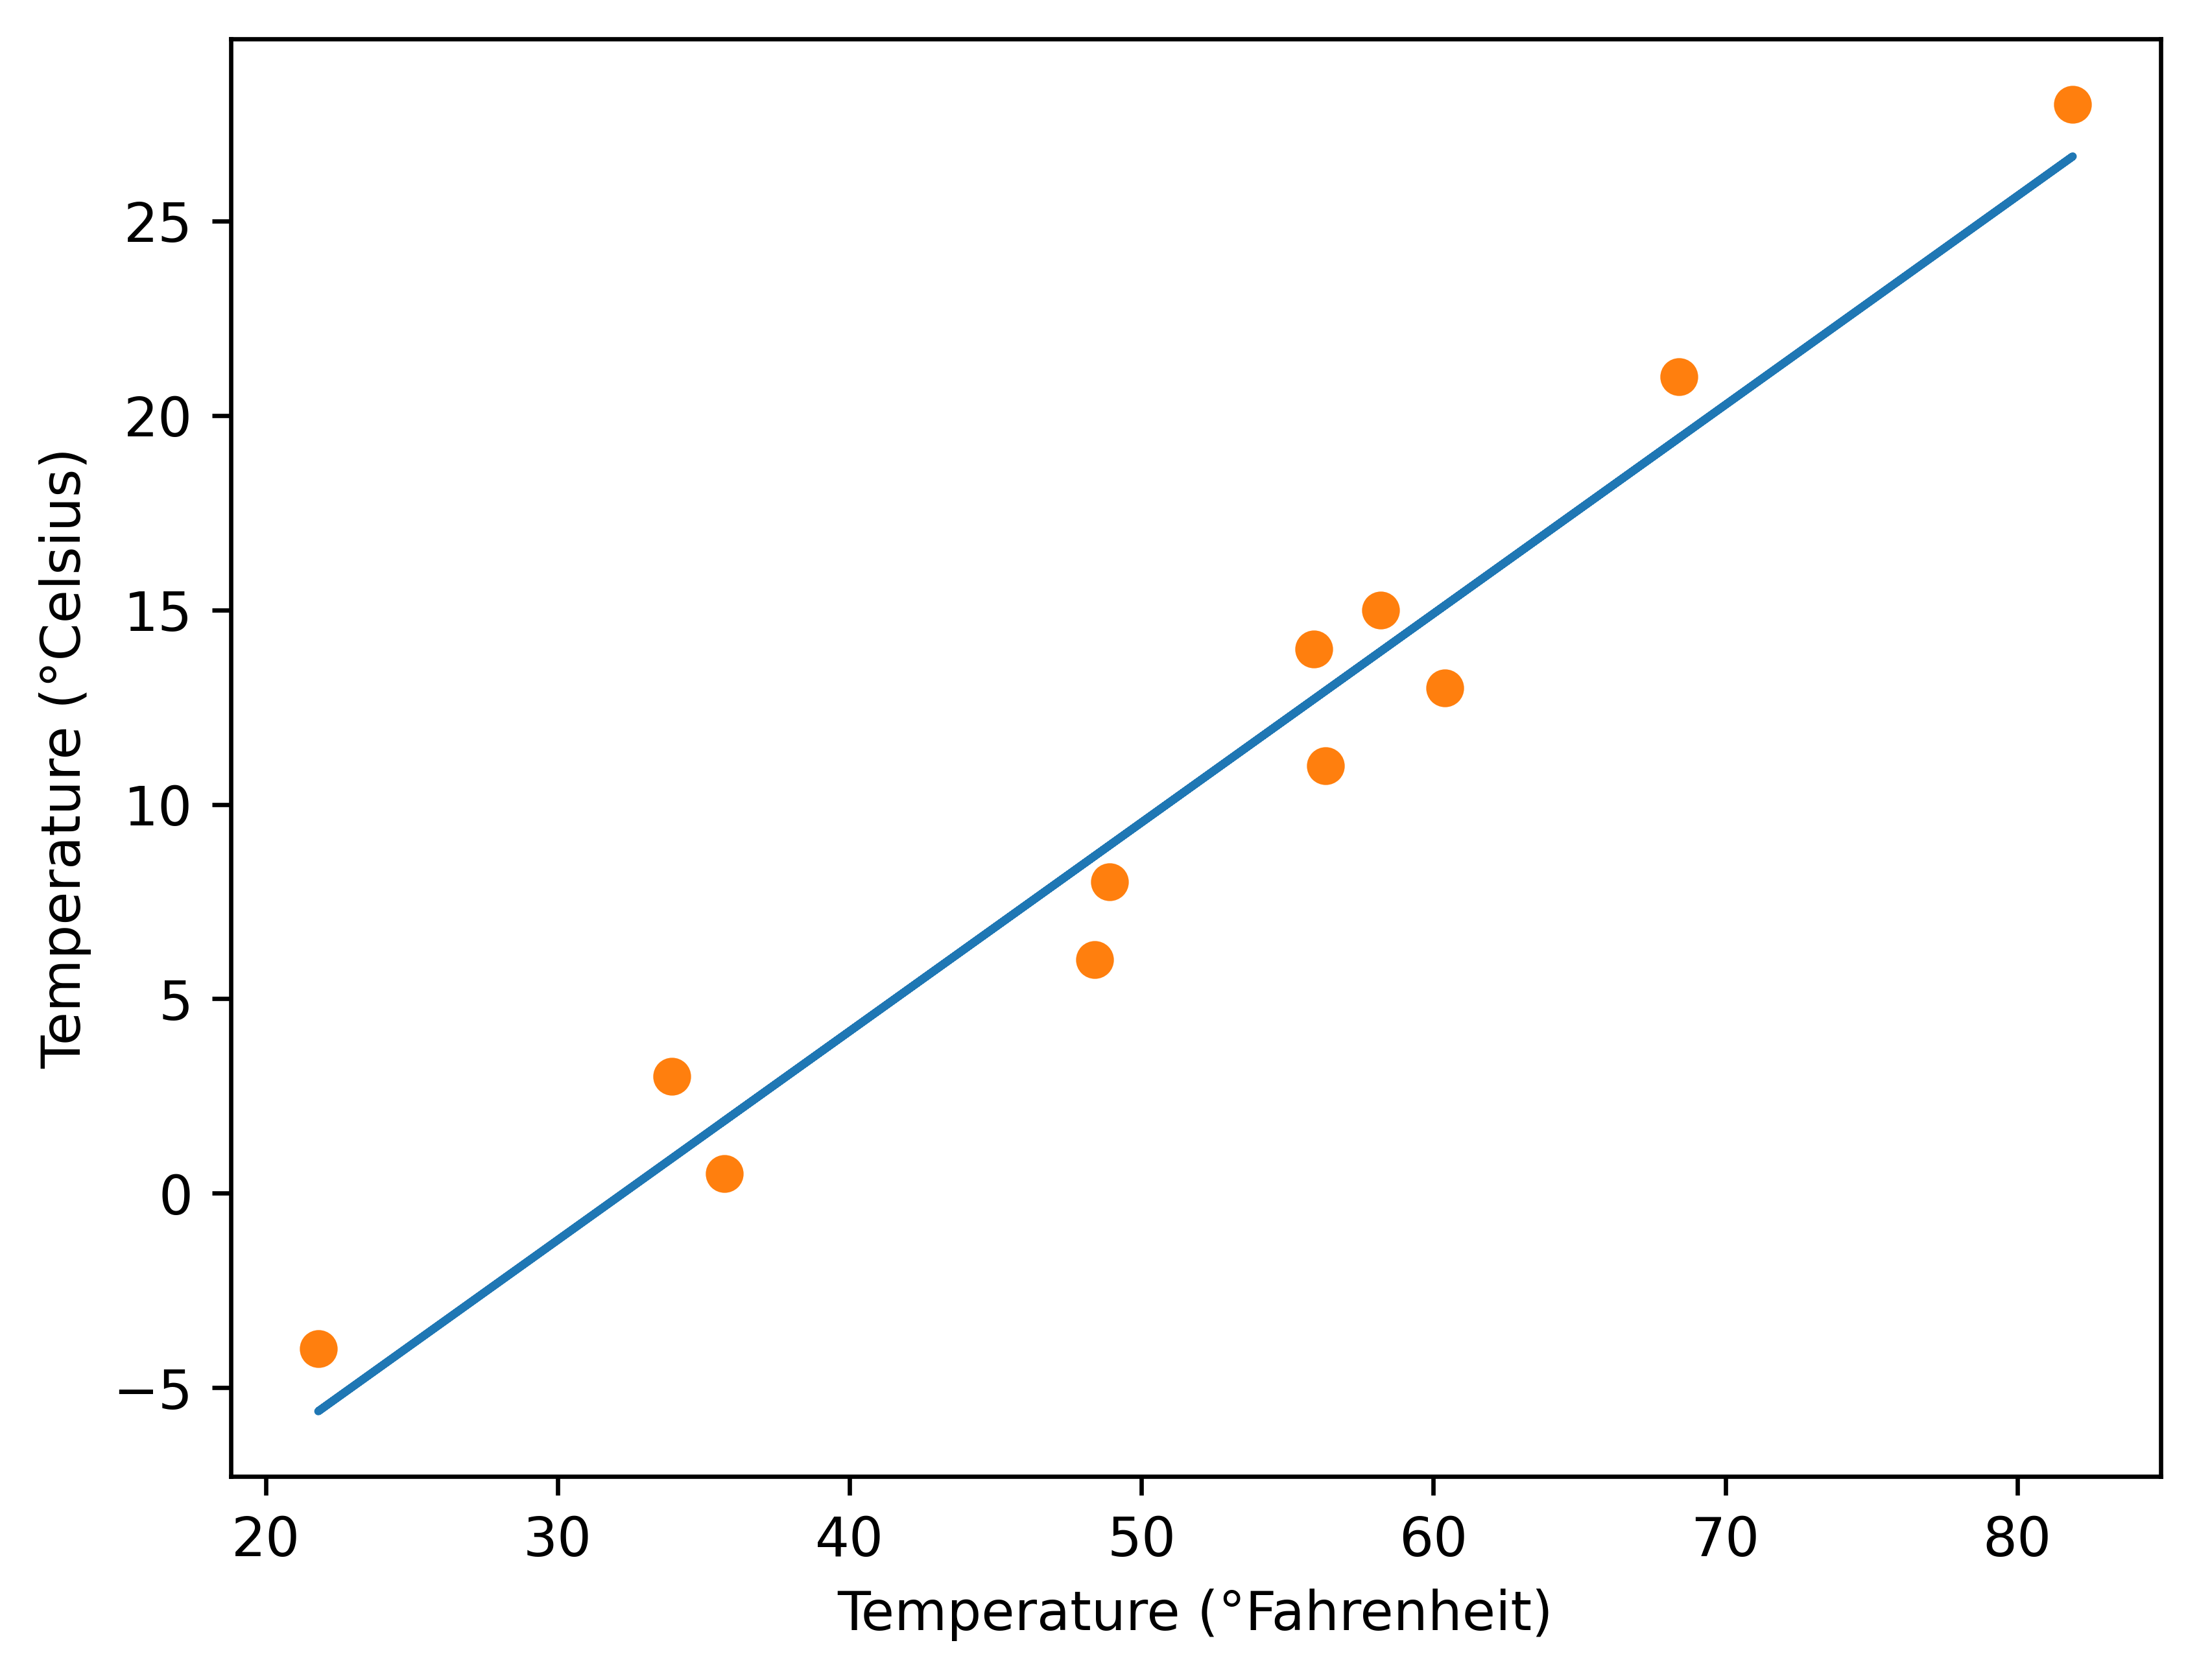

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

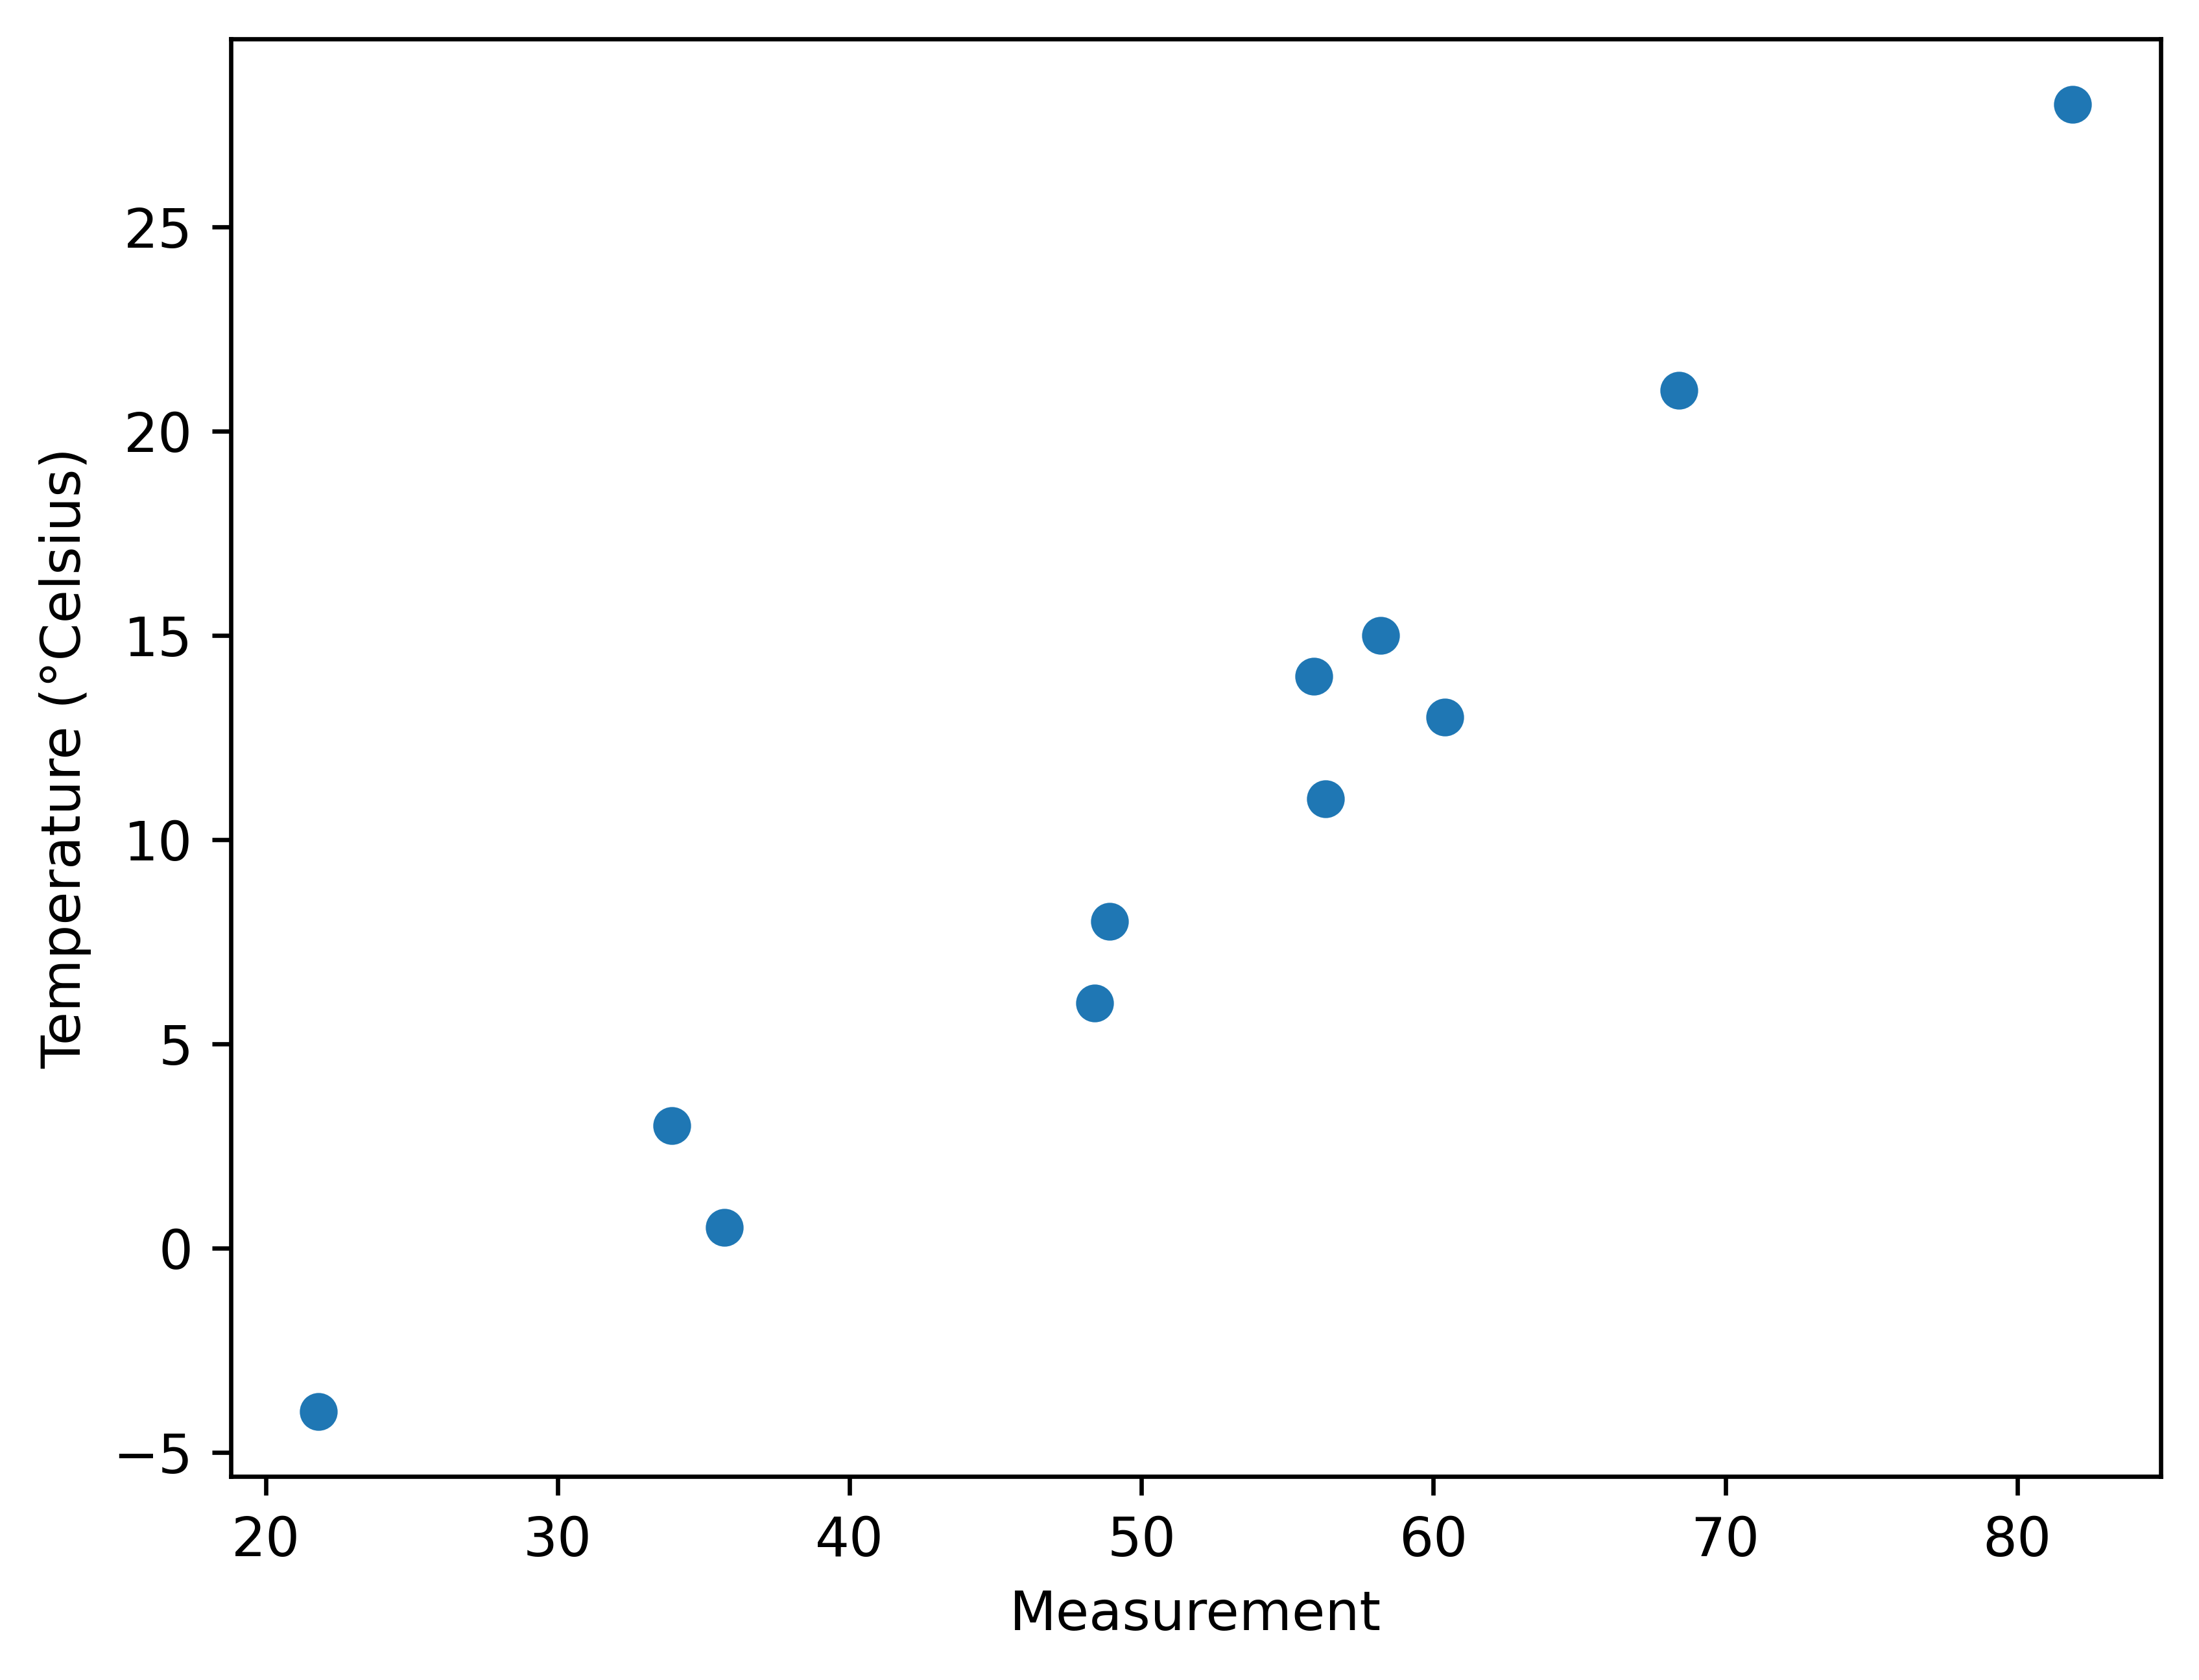

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

plt.savefig("temp_data_plot.png", format="png")